In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt



In [2]:
import aqml.cheminfo.lo.dmml as cll
reload(cll)
import numpy as np
from aqml.cheminfo.lo.dmml import *
from aqml.cheminfo.lo.dmx import *
import ase.io as aio

In [3]:
def get_dmxs(fs, objs, brs, bq):
    o1,o2 = objs

    #fs = [ 'test/'+fi+'.xyz' for fi in ['c06h14', 'c12h26'] ] #'c07h16', 'c08h18',
    ms = [ aio.read(f) for f in fs ]
    m1, m2 = ms

    mr,mq = m1,m2
    brsc = [] # BondS of Ref Chosen for training
    y1 = []
    dm2 = clb.get_dm_aa(o2,bq[0],bq[1])
    y2 = np.array([ dm2.ravel() ])
    for br in brs:
        dm1 = clb.get_dm_aa(o1,br[0],br[1])
        ots = clb.get_mapping(mr,br,mq,bq)
        if len(ots) == 0: continue
        i1, i2 = ots
        dm1u = dm1[i1][:,i2]
        y1.append(dm1u.ravel()); brsc.append(br)
        print( 'bond=(%3d,%3d)'%(br[0],br[1]), ' max deviation: %.5f'% np.max(np.abs(dm1u-dm2)) )
    y1 = np.array(y1)
    return brsc, y1, y2


In [4]:
import ase.visualize as av
import ase
import numpy as np
import ase.io as aio

np.set_printoptions(precision=4,suppress=True)

fs = [ 'test/'+fi+'.xyz' for fi in ['c06h14', 'c07h16', 'c08h18','c12h26'] ]
ms = [ aio.read(f) for f in fs ]
m1, m2, m3, m4 = ms
#av.view(m4); av.view(m1)

In [5]:
#from MDAnalysis.analysis import align
#R, rmsd = align.rotation_matrix(q.positions, ref.positions)
#ref_u = ref.copy()
#ref_u.positions = np.dot(ref.positions,R)
#av.view(ref_u)
#av.view(q)

In [31]:
import aqml.cheminfo.lo.dmb as clb
reload(clb)

<module 'cheminfo.lo.dmb' from '/Users/bhuang/Dropbox/workspace/python/cheminfo/lo/dmb.py'>

In [7]:
fs = [ 'test/'+fi+'.xyz' for fi in ['c06h14', 'c12h26'] ] #'c07h16', 'c08h18',
objs = clb.ready_pyscf(fs)

(' now ', 'test/c06h14.xyz')
converged SCF energy = -234.09627537053
(' now ', 'test/c12h26.xyz')
converged SCF energy = -467.009800442334


In [38]:
fs = [ 'test/'+fi+'.xyz' for fi in ['c06h14', 'c06h14'] ] #'c07h16', 'c08h18',
scales = [1., 0.9]
objs1 = clb.ready_pyscf(fs,scales)

(' now ', 'test/c06h14.xyz')
('     + scaling_factor = ', 1.0)
converged SCF energy = -234.09627537053
(' now ', 'test/c06h14.xyz')
('     + scaling_factor = ', 0.9)
converged SCF energy = -233.852074489251


In [39]:
o1,o2 = objs1
clb.get_dm_aa(o2, 0, 1) - clb.get_dm_aa(o1, 0, 1)

array([[-0.0017, -0.0162, -0.0005, -0.0027, -0.0027],
       [-0.0158,  0.0014, -0.0113, -0.0077, -0.0077],
       [-0.0023, -0.0052, -0.0042, -0.0049,  0.0105],
       [-0.0024, -0.0034,  0.016 , -0.0054, -0.0054],
       [-0.0023, -0.0052, -0.0042,  0.0105, -0.0049]])

In [40]:
fs = [ 'test/'+fi+'.xyz' for fi in ['c06h14' ] ] #'c07h16', 'c08h18',
scales = [1.1]
objs2 = clb.ready_pyscf(fs,scales)
o3 = objs2[0]

(' now ', 'test/c06h14.xyz')
('     + scaling_factor = ', 1.1)
converged SCF energy = -233.936716080608


In [41]:
clb.get_dm_aa(o3, 0, 1) - clb.get_dm_aa(o1, 0, 1)

array([[ 0.0009,  0.0109,  0.0006,  0.0024,  0.0024],
       [ 0.0105,  0.0074,  0.0053,  0.0041,  0.0041],
       [ 0.0022,  0.0042,  0.0025,  0.0039, -0.0056],
       [ 0.0021,  0.0027, -0.0103,  0.004 ,  0.004 ],
       [ 0.0022,  0.0042,  0.0025, -0.0056,  0.0039]])

In [26]:


np.set_printoptions(formatter={'float': '{: 0.8f}'.format})

basis='sto-3g'; meth='b3lyp'
spin=0; a=0.; verbose=3

zs = []; coords = []; nas = []
for fi in fs:
    mi = aio.read(fi)
    nas.append(len(mi)); zs += list(mi.numbers); coords += list(mi.positions)
nas = np.array(nas,np.int)
zs = np.array(zs,np.int)
coords = np.array(coords)


racut,rbcut = 1.6,4.8 # 4.8, 4.8
xd = XData(nas, zs, coords)
xd.get_x(param={'racut':racut,'rbcut':rbcut})
#yd = YData(nas, zs, coords, rc_dm=rbcut)
#obj = dmml(xd,yd)


In [27]:
xs = np.array( xd.xsb )
assert not np.any(np.isnan(xs))
obj = dmml(xd)

In [28]:

def get_lc(fs, objs, ims1, ims2, brs, bq):
    brsc, y1, y2 = get_dmxs(fs, objs, brs, bq)

    opt = 'ii'
    idxs_x1 = xd.get_idx(brsc, ims=ims1, opt=opt)
    idxs_x2 = xd.get_idx([bq], ims=ims2, opt=opt)
    x1, x2 = xs[idxs_x1], xs[idxs_x2]

    n2 = 1
    n1s = np.arange(1,len(brsc)+1)
    errs = []
    for n1 in n1s:
        ds2, y2_est = obj.krr(x1[:n1],y1[:n1],x2,kernel='g',c=1.0,l=1.e-8)
        dy2 = np.abs(y2_est-y2)
        denom = n2 * dy2.shape[1]
        mae, rmse, errmax = np.sum(dy2)/denom, np.sqrt(np.sum(dy2**2)/denom), np.max(dy2)
        errs.append([mae, rmse, errmax])
        print('  n1,  mae, rmse, delta_max = %d, %.5f %.5f %.5f'%(n1, mae, rmse, errmax) )
    return n1s, errs


In [42]:
bq = [0,12]
brs = [[2,11],[1,9],[0,6],[0,7] ]
ims1, ims2 = [0], [1]
n1s, errs = get_lc(fs, objs, ims1, ims2, brs, bq)
ots = plt.loglog(n1s, errs, '-o')
#print( np.max(np.))

ValueError: need more than 1 value to unpack

 * Warning: you may need mirror symmetry to rectify this!
            For now, we simply neglect such case, i.e., skip
            this very bond as a training point
('bond=(  0, 10)', ' max deviation: 0.01150')
 * Warning: you may need mirror symmetry to rectify this!
            For now, we simply neglect such case, i.e., skip
            this very bond as a training point
 * Warning: you may need mirror symmetry to rectify this!
            For now, we simply neglect such case, i.e., skip
            this very bond as a training point
('bond=(  1, 11)', ' max deviation: 0.00007')
 * Warning: you may need mirror symmetry to rectify this!
            For now, we simply neglect such case, i.e., skip
            this very bond as a training point
('bond=(  2,  9)', ' max deviation: 0.00054')
 * Warning: you may need mirror symmetry to rectify this!
            For now, we simply neglect such case, i.e., skip
            this very bond as a training point
('bond=(  2, 13)', ' max deviati

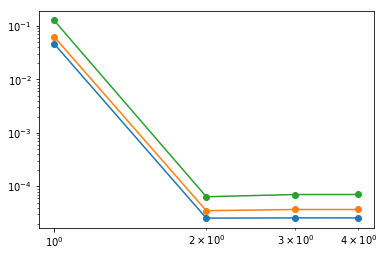

In [12]:
bq = [1,17]
brs = [[0,9],[0,10],[1,6],[1,7],[1,11],[1,12],[2,9],[2,10],[2,13],[2,14] ]
ims1, ims2 = [0], [1]
n1s, errs = get_lc(fs, objs, ims1, ims2, brs, bq)
ots = plt.loglog(n1s, errs, '-o')

('bond=(  0,  1)', ' max deviation: 0.02721')
('bond=(  2,  3)', ' max deviation: 0.00107')
('bond=(  1,  2)', ' max deviation: 0.00005')
  n1,  mae, rmse, delta_max = 1, 0.04580 0.13445 0.66280
  n1,  mae, rmse, delta_max = 2, 0.00308 0.00861 0.04222
  n1,  mae, rmse, delta_max = 3, 0.00001 0.00002 0.00006


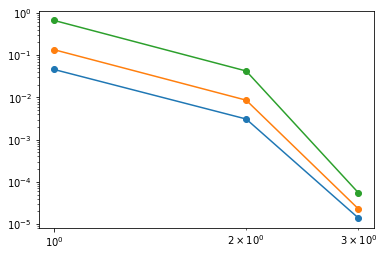

In [13]:
bq = [1,2]
brs = [[0,1],[2,3],[1,2], ]
ims1, ims2 = [0], [1]
n1s, errs = get_lc(fs, objs, ims1, ims2, brs, bq)
ots = plt.loglog(n1s, errs, '-o')

('bond=(  0,  2)', ' max deviation: 0.00560')
('bond=(  2,  4)', ' max deviation: 0.00043')
('bond=(  1,  3)', ' max deviation: 0.00019')
  n1,  mae, rmse, delta_max = 1, 0.01917 0.02945 0.10195
  n1,  mae, rmse, delta_max = 2, 0.00163 0.00242 0.00760
  n1,  mae, rmse, delta_max = 3, 0.00003 0.00005 0.00018


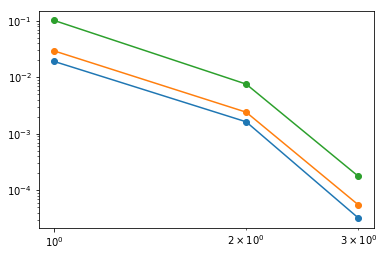

In [14]:
bq = [1,3]
brs = [[0,2],[2,4],[1,3], ]
ims1, ims2 = [0], [1]
n1s, errs = get_lc(fs, objs, ims1, ims2, brs, bq)
ots = plt.loglog(n1s, errs, '-o')

('bond=(  0,  3)', ' max deviation: 0.00914')
('bond=(  2,  5)', ' max deviation: 0.00918')
('bond=(  1,  4)', ' max deviation: 0.00068')
  n1,  mae, rmse, delta_max = 1, 0.01064 0.02641 0.12153
  n1,  mae, rmse, delta_max = 2, 0.00108 0.00187 0.00534
  n1,  mae, rmse, delta_max = 3, 0.00019 0.00032 0.00110


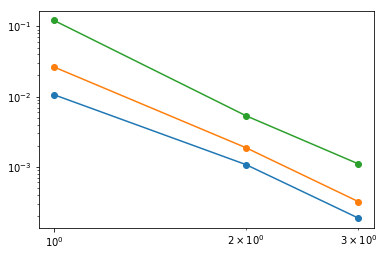

In [30]:
bq = [2,5]
brs = [[0,3],[2,5],[1,4], ]
ims1, ims2 = [0], [1]
n1s, errs = get_lc(fs, objs, ims1, ims2, brs, bq)
ots = plt.loglog(n1s, errs, '-o')